In [1]:
import os

import numpy as np
import tensorflow as tf

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from transformers import TFGPT2LMHeadModel

from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize

c:\users\seaofglass\appdata\local\programs\python\python37\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In [2]:
class GPT2Model(tf.keras.Model):
    def __init__(self, dir_path):
        super(GPT2Model, self).__init__()
        self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)
        
    def call(self, inputs):
        return self.gpt2(inputs)[0]

In [3]:
gpt_model = GPT2Model('./gpt_ckpt')

In [4]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30

TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token=None,
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [5]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-99999):
    _logits = logits.numpy()
    top_k = min(top_k, logits.shape[-1])  
    if top_k > 0:
        indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
        _logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits = tf.sort(logits, direction='DESCENDING')
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
        indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()
        
        _logits[indices_to_remove] = filter_value
    return tf.constant([_logits])


def generate_sent(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.):
    sent = seed_word
    toked = tokenizer(sent)
    
    for _ in range(max_step):
        input_ids = tf.constant([vocab[vocab.bos_token],]  + vocab[toked])[None, :] 
        outputs = model(input_ids)[:, -1, :]
        if greedy:
            gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
        else:
            output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
            gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
        if gen == '</s>':
            break
        sent += gen.replace('▁', ' ')
        toked = tokenizer(sent)

    return sent

In [8]:
generate_sent('호텔', gpt_model, greedy=True)

'호텔신라가 호텔신라의 지분을 인수하기로 한 것은 이번이 처음이다.'

In [9]:
generate_sent('호텔', gpt_model, top_k=0, top_p=0.95)

'호텔 테라스가 내려다 보이는 길을 따라 길게 줄을 서 기다리면 된다.'

In [10]:
sents = [s[:-1] for s in open("data/total_slogan.txt", encoding='utf-8-sig').readlines()]

In [11]:
input_data = []
output_data = []

for s in sents:
    tokens = [vocab[vocab.bos_token],]  + vocab[tokenizer(s)] + [vocab[vocab.eos_token],]
    input_data.append(tokens[:-1])
    output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [13]:
gpt_model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(1e-4), metrics=[accuracy_function])

In [14]:
history = gpt_model.fit(input_data, output_data, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=0.1)

Train on 28747 samples, validate on 3195 samples
Epoch 1/10


c:\users\seaofglass\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\seaofglass\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


28747/28747 [==============================] - 260s 9ms/sample - loss: 1.3089 - accuracy_function: 0.0674 - val_loss: 1.1845 - val_accuracy_function: 0.0743
Epoch 2/10
28747/28747 [==============================] - 263s 9ms/sample - loss: 1.1218 - accuracy_function: 0.0796 - val_loss: 1.1927 - val_accuracy_function: 0.0829
Epoch 3/10
28747/28747 [==============================] - 245s 9ms/sample - loss: 0.9924 - accuracy_function: 0.0870 - val_loss: 1.2212 - val_accuracy_function: 0.0900
Epoch 4/10
28747/28747 [==============================] - 250s 9ms/sample - loss: 0.8737 - accuracy_function: 0.0939 - val_loss: 1.2799 - val_accuracy_function: 0.0970
Epoch 5/10
28747/28747 [==============================] - 249s 9ms/sample - loss: 0.7684 - accuracy_function: 0.1007 - val_loss: 1.3371 - val_accuracy_function: 0.1037
Epoch 6/10
28747/28747 [==============================] - 251s 9ms/sample - loss: 0.6762 - accuracy_function: 0.1074 - val_loss: 1.4166 - val_accuracy_function: 0.1103
Epo

In [15]:
import matplotlib.pyplot as plt

In [16]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

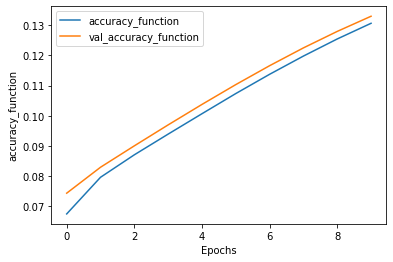

In [18]:
plot_graphs(history, 'accuracy_function')

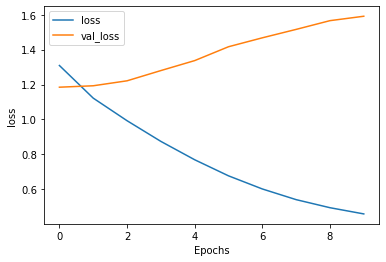

In [19]:
plot_graphs(history, 'loss')

In [20]:
save_path = os.path.join('./data_out', "tf2_gpt2_finetuned_model")

if not os.path.exists(save_path):
    os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

In [27]:
generate_sent('호텔', gpt_model, greedy=True)

'호텔침실만 보면 “여기가 우리집이었음..”하는 부부에 맞춰 롯데마트가 맞춤 세탁을 시작합니다. 오늘의 옥션이었습니다. 오늘의'

In [37]:
generate_sent('호텔', gpt_model, top_k=0, top_p=0.80)

'호텔침대에서 혼자 셀카를 찍다 깜빡했을지도 모를 일이다. 내 모바일에 이런 포샵이 있나? ... 좀 보여주까?'